Je propose de mettre cette sous partie d'analyse en foncion de wine_type dans la partie analyse des variables car en vrai c'est pas partie du modèle. 

## 0 - Démarches préliminaires

### 0.a- Importation des librairies 

In [3]:
#general librairies
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd

#sklearn librairies
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.linear_model import *
from sklearn.ensemble import * 
from sklearn.svm import *
import statsmodels.api as sm
import xgboost as xgb

#appel a nos fonctions
from fcts_R.general import * 
from fcts_R.dataset_division import *

### 0.b - On télécharge le jeu de données train

In [4]:
#On charge le jeu de données
data = pd.read_csv("datasets_c/wine_train.csv")

Dans la suite, on va tenter de faire des regressions sur chaque type de vin

## 1 - Traitement du jeu de données 

### a- Séparation du jeu de données initial en fonction de wine_type

In [5]:
#on extrait indices dans lequels la variable "wine_type"= 0 (resp. = 1)
#idx0, idx1 = winetype(data)

#on crée les jeu de données data0 et data1 à partir des indices 
#data0, data1 = formal_div(data, idx0, idx1)

#data0.to_csv("datasets_c/data0.csv")
#data1.to_csv("datasets_c/data1.csv")

### b - Séparation train/test: 
Cette division nous permettra d'évaluer les performances de nos modèles en contrôlant l'erreur test. 

In [6]:
data0 = pd.read_csv("datasets_c/data0.csv")
data1 = pd.read_csv("datasets_c/data1.csv")


#On sépare les co-variables de la variable à prédire
X0,y0 = treatment(data0)
X1,y1 = treatment(data1)

#Data0: 
X_tr0, X_te0, y_tr0, y_te0= train_test_split(X0,y0, test_size=0.33,random_state=2023)

#Data1:
X_tr1, X_te1, y_tr1, y_te1= train_test_split(X1,y1, test_size=0.33,random_state=2023)

### c - Normalisation des co-variables
Cette démarche nous permettra d'éviter des problèmes d'unité 

In [7]:
#Pour data0: 
stdsc = StandardScaler()
X_tr_0 = stdsc.fit_transform(X_tr0)
X_te_0 = stdsc.transform(X_te0)

#Pour data1: 
stdsc = StandardScaler()
X_tr_1 = stdsc.fit_transform(X_tr1)
X_te_1 = stdsc.transform(X_te1)

f - Étude de l'importance des covariables

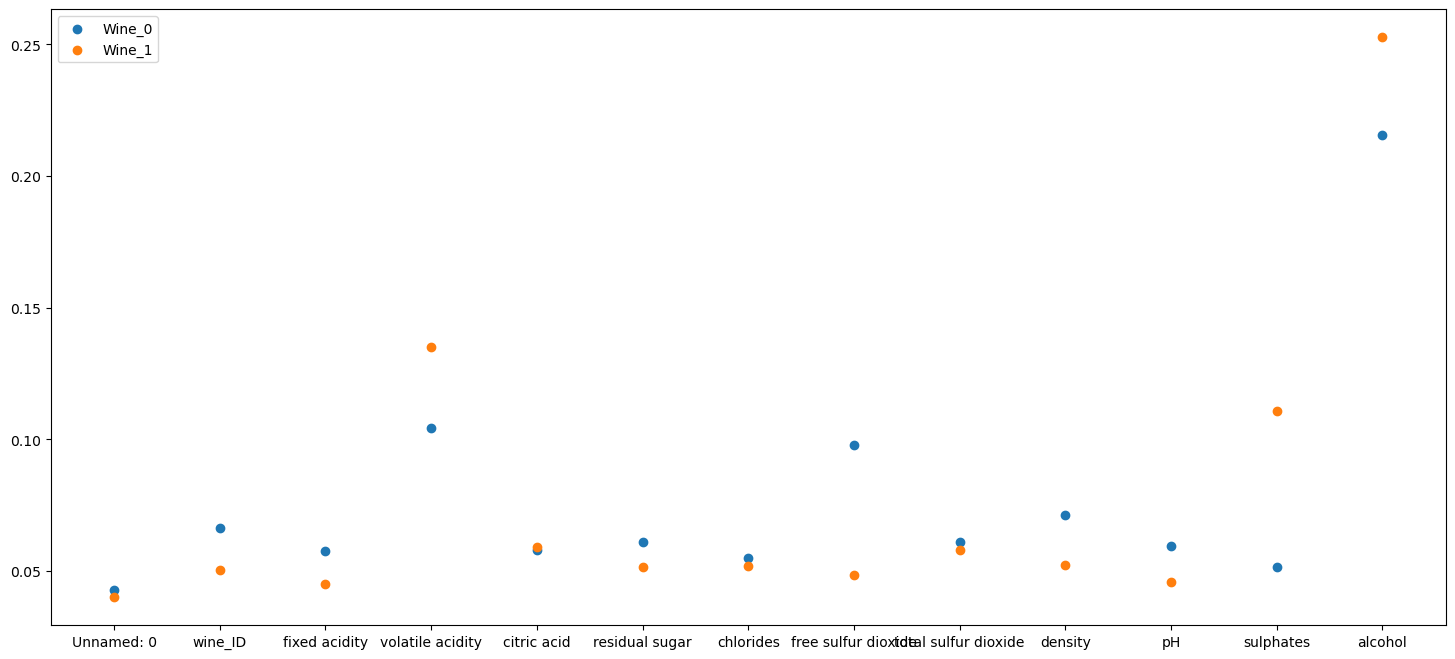

In [9]:
model0 = ExtraTreesRegressor(random_state=50, max_samples=None, n_estimators=1000, bootstrap=True)
model0.fit(X_tr_0, y_tr0.to_numpy().ravel())

model1 = ExtraTreesRegressor(random_state=50, max_samples=None, n_estimators=2750, bootstrap=True)
model1.fit(X_tr_1,y_tr1.to_numpy().ravel())

fig, ax = plt.subplots(figsize=(18,8))
plt.scatter(X_tr0.columns ,model0.feature_importances_, label="Wine_0")
plt.scatter(X_tr1.columns ,model1.feature_importances_, label="Wine_1")
plt.legend()

## 2 - Selection et entrainement de modèles

### a - Selection de paramètres et modèles basés sur la cross-validation

### 1 -  Modèles lineaires avec choix de variables

Modèle entraîné sur data0

In [10]:
# Pour implementer cette méthode on devra renommer les variables: 
data_0 = data0.copy()
stdsc = StandardScaler()
data_0 = pd.DataFrame(stdsc.fit_transform(data_0), columns=data_0.columns)
data_0 = data_0.rename(columns={"volatile acidity":"volatile_acidity", "free sulfur dioxide": "free_sulfur_dioxide", "fixed acidity": "fixed_acidity", "citric acid": "citric_acid", "residual sugar":"residual_sugar", "total sulfur dioxide": "total_sulfur_dioxide"})

X = data_0[data_0.columns[0:-1]]
y = data_0["target"]
X_tr, X_te, y_tr, y_te= train_test_split(X,y, test_size=0.33,random_state=2023)

X_tr["target"] = y_tr

In [11]:
#Pour le choix des variables, nous avons commencé avec toutes les variables puis on a enlevé celle qui donnait le meilleur score à chaque fois
model_formula0 = "target ~ alcohol + sulphates + pH + density + free_sulfur_dioxide + volatile_acidity + wine_ID + residual_sugar "
# Define the model
model0 = sm.OLS.from_formula(model_formula0, data=X_tr)

# Fit the model
results0 = model0.fit()

# View the regression summary
print(results0.summary())

y_pred0 = results0.predict(X_te)
r2_score(y_te, y_pred0)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.278
Model:                            OLS   Adj. R-squared:                  0.276
Method:                 Least Squares   F-statistic:                     109.7
Date:                Wed, 08 Nov 2023   Prob (F-statistic):          3.26e-155
Time:                        15:23:42   Log-Likelihood:                -2842.1
No. Observations:                2285   AIC:                             5702.
Df Residuals:                    2276   BIC:                             5754.
Df Model:                           8                                         
Covariance Type:            nonrobust  

0.32790909887441744

Modèle entraîné sur data1

In [12]:
#À nouveau, nous devrons renommer les colonnes
data_1 = data1.copy()
stdsc = StandardScaler()
data_1 = pd.DataFrame(stdsc.fit_transform(data_1), columns=data_1.columns)
data_1 = data_1.rename(columns={"volatile acidity":"volatile_acidity", "free sulfur dioxide": "free_sulfur_dioxide", "fixed acidity": "fixed_acidity", "citric acid": "citric_acid", "residual sugar":"residual_sugar", "total sulfur dioxide": "total_sulfur_dioxide"})

X = data_1[data_1.columns[0:-1]]
y = data_1["target"]
X_tr, X_te, y_tr, y_te= train_test_split(X,y, test_size=0.33,random_state=2023)

X_tr["target"] = y_tr

In [13]:
model_formula1 = "target ~ alcohol + sulphates + density  + volatile_acidity+ fixed_acidity + citric_acid + residual_sugar "
# Define the model
model1 = sm.OLS.from_formula(model_formula1, data=X_tr)

# Fit the model
results1 = model1.fit()

# View the regression summary
print(results1.summary())

y_pred1 = results1.predict(X_te)
r2_score(y_te, y_pred1)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     60.95
Date:                Wed, 08 Nov 2023   Prob (F-statistic):           2.65e-69
Time:                        15:23:47   Log-Likelihood:                -910.07
No. Observations:                 761   AIC:                             1836.
Df Residuals:                     753   BIC:                             1873.
Df Model:                           7                                         
Covariance Type:            nonrobust  

0.3502292206725519

#### 2- SVM

Modèle entrainé sur data0

In [15]:
# {'kernel': ["linear","poly","rbf", "sigmoid"], 'gamma':["scale", "auto"], 'epsilon':[0.05,0.1,0.15], 'C': [0.5,1,1.5]}
#Best Hyperparameters:  {'C': 1, 'epsilon': 0.15, 'gamma': 'scale', 'kernel': 'rbf'}; Best Score:  0.37465693229921293; normal:  0.40728418982541437 

#{'degree': [1,2,3,4,5,6]}, SVR(kernel="poly", gamma="scale", epsilon=0.15)
#Best Hyperparameters:  {'degree': 1}; Best Score:  0.26182202519203174; normal:  0.3233410341186739

#{'degree': [1,2,3,4,5,6], 'coef0': [0.0, 0.01, 0.1, 0.5, 0.75,1]}, SVR(kernel="poly", gamma="scale", epsilon=0.15)
#Best Hyperparameters:  {'coef0': 1, 'degree': 2}; Best Score:  0.31889755456529084; normal:  0.26912361991020595

#{'C': [0.75,0.9,1,1.1,1.25]}, SVR(kernel="rbf", gamma="scale", epsilon=0.15)
#Best Hyperparameters:  {'C': 1}; Best Score:  0.37465693229921293; normal:  0.40728418982541437

#{'loss': ["epsilon_insensitive", "squared_epsilon_insensitive"], 'epsilon': [0,0.01,0.05,0.1,0.2,0.5],  'C': [0.5,1,1.5]},LinearSVR()
# Best Hyperparameters:  {'C': 1.5, 'epsilon': 0, 'loss': 'squared_epsilon_insensitive'}; Best Score:  0.26364596987343536; normal:  0.3142987698900451

#BEST SCORE: 
#params = {'kernel': ["linear","poly","rbf", "sigmoid"], 'gamma':["scale", "auto"], 'nu':[0.25,0.4,0.5,0.6,0.75,1], 'C': [0.5,1,1.5]}, NuSVR()
# Best Hyperparameters:  {'C': 1.5, 'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.6}; Best Score:  0.3825024346626745; normal:  0.4170237776338953

params = {'kernel': ["linear","poly","rbf", "sigmoid"], 'gamma':["scale", "auto"], 'nu':[0.25,0.4,0.5,0.6,0.75,1], 'C': [0.5,1,1.5]}
pred0 = param_selection(params, NuSVR(), X_tr_0, y_tr0.to_numpy().ravel(), X_te_0)

print("erreur test: ", r2_score(y_te0, pred0))

Best Hyperparameters:  {'C': 1, 'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.6}
Best Score:  0.3692312928254857
normal:  0.40566250675181714


Modèle entrainé sur data1

In [21]:
#pred_SVM1 = param_selection({'kernel': ["linear","poly","rbf", "sigmoid"], 'gamma':["scale", "auto"], 'epsilon':[0.05,0.1,0.15], 'C': [0.5,1,1.5]}, SVR(gamma='auto'), X_tr_1,y_tr1, X_te_1)
# Best Hyperparameters:  {'C': 0.5, 'epsilon': 0.15, 'gamma': 'scale', 'kernel': 'rbf'}; Best Score:  0.36646962843446423

#pred_SVM1 = param_selection({'kernel': ["linear","poly","rbf"], 'epsilon':[0.01,0.1,0.2]}, SVR(gamma="auto"), X_tr_1, y_tr1, X_te_1)
# Best Hyperparameters:  {'epsilon': 0.2, 'kernel': 'rbf'}; Best Score:  0.37085380472521134

#pred_SVM1 = param_selection({'degree': [1,2,3,4]}, SVR(gamma="auto", kernel="poly", epsilon=0.2), X_tr_1, y_tr1, X_te_1)
#Best Hyperparameters:  {'degree': 1}; Best Score:  0.3486973341420462

#pred_SVM1 = param_selection({'loss': ["epsilon_insensitive", "squared_epsilon_insensitive"], 'epsilon': [0,0.01,0.05,0.1,0.2,0.5],  'C': [0.5,1,1.5]},LinearSVR(), X_tr_1,y_tr1,X_te_1)
#Best Hyperparameters:  {'C': 1, 'epsilon': 0.2, 'loss': 'epsilon_insensitive'}; Best Score:  0.34926931350937107

# pred_SVM1 = param_selection({'loss': ["epsilon_insensitive", "squared_epsilon_insensitive"], 'epsilon': [0,0.01,0.05,0.1,0.2,0.5],  'C': [0.5,1,1.5]},LinearSVR(), X_tr_1, y_tr1, X_te_1)
# Best Hyperparameters:  {'C': 1, 'epsilon': 0.2, 'loss': 'epsilon_insensitive'}; Best Score:  0.34948012695417774

#BEST SCORE
#pred_SVM1 = param_selection({'kernel': ["linear","poly","rbf", "sigmoid"], 'gamma':["scale", "auto"], 'nu':[0.25,0.4,0.5,0.6,0.75,1], 'C': [0.5,1,1.5]}, NuSVR(), X_tr_1,y_tr1,X_te1)
# Best Hyperparameters:  {'C': 1, 'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.5}; Best Score:  0.37920360670150177
pred_SVM1 = NuSVR(kernel="rbf", gamma="scale", nu=0.5,C=1).fit(X_tr_1,y_tr1.to_numpy().ravel()).predict(X_te_1)

print("erreur test: ", r2_score(y_te1, pred_SVM1))

erreur test:  0.3745598443683087


### 3- XGBoost

Modèle entraîné sur data0

In [24]:
# preds = param_selection({'n_estimators': [95,100,105]}, xgb.XGBRegressor(seed = 2023, objective="reg:squarederror"), X_tr_0, y_tr0, X_te_0)
# Best Hyperparameters:  {'n_estimators': 100}; Best Score:  0.377947838196242

#BEST SCORE
preds0 = param_selection({'n_estimators': [100,150, 200, 250,300]}, xgb.XGBRFRegressor(random_state=50), X_tr_0, y_tr0, X_te_0)
# Best Hyperparameters:  {'n_estimators': 200}; Best Score:  0.32986538836899715

print("erreur test",r2_score(y_te0, preds0))

Best Hyperparameters:  {'n_estimators': 150}
Best Score:  0.3286218368868324
erreur test 0.3954196853517815


Modèle entrainé sur data1

In [25]:
# preds1 = param_selection({'objective':["reg:linear", "reg:squarederror", "reg:tweedie", "reg:huber"],'n_estimators': [10,50,75,100,150,200]}, xgb.XGBRegressor(seed = 2023), X_tr_1, y_tr1, X_te_1)
# Best Hyperparameters:  {'n_estimators': 10, 'objective': 'reg:linear'}; Best Score:  0.37838078901841915

# preds1 = param_selection({'objective':["reg:linear", "reg:squarederror"],'n_estimators': [5,10, 15,20]}, xgb.XGBRegressor(random_state = 2023), X_tr_1, y_tr1, X_te_1)
# Best Hyperparameters:  {'n_estimators': 10, 'objective': 'reg:linear'}; Best Score:  0.37838078901841915

#BEST SCORE
preds1 = param_selection({'n_estimators': [415, 420, 425]}, xgb.XGBRFRegressor(seed=2023), X_tr_1, y_tr1, X_te_1)
#Best Hyperparameters:  {'n_estimators': 420}; Best Score:  0.40799724415966443

print("erreur test: ",r2_score(y_te1, preds1))

Best Hyperparameters:  {'n_estimators': 415}
Best Score:  0.40799724415966443
erreur test 0.37489969193217565


### 4 - Méthodes d'ensembles

Modèle entrainé sur data0

In [26]:
#param_grid = {"learning_rate":[0.01, 0.05,0.1,0.15]}
#mod = GradientBoostingRegressor(random_state=10, loss="huber", learning_rate= 0.15)
#Best Score:  0.3803194835261793

#param_grid = {loss:['squared_error', 'absolute_error', 'poisson', 'quantile'],"learning_rate":[0.15,0.1,0.075]}
#mod = HistGradientBoostingRegressor(random_state=10, loss="poisson", learning_rate= 0.15)
#Best Score:  0.4212414218497866

#param_grid = {'n_estimators': [1750,2000,2250]}
#mod = BaggingRegressor(random_state=10, n_estimators=2250)
# Best Hyperparameters:  {'n_estimators': 2250}; Best Score:  0.4322135469402454

#BEST SCORE
param_grid  = {'n_estimators': [900,1000,1100]}
pred0 = param_selection(param_grid, ExtraTreesRegressor(random_state=50, max_samples=None), X_tr_0, y_tr0.to_numpy().ravel(), X_te_0)
#Best Hyperparameters:  {'n_estimators': 1000}; Best Score:  0.445343694590953

print("erreur test: ", r2_score(y_te0, pred0))

Best Hyperparameters:  {'n_estimators': 1000}
Best Score:  0.445343694590953
normal:  0.5123931993006859


Modèle entrainé sur data1

In [42]:
#param_grid = {'n_estimators': [400,500]}
#mod = BaggingRegressor(random_state=10)
#Best Hyperparameters:  {'n_estimators': 500}; Best Score:  0.4415537219663822

#BEST SCORE 
#param_grid = {'n_estimators': [300,2750,100]}
#pred1 = param_selection(param_grid, ExtraTreesRegressor(random_state=50, max_samples=None), X_tr_1, y_tr1.to_numpy().ravel(), X_te_1)
#Best Hyperparameters:  {'n_estimators': 2750}; Best Score:  0.44143303715384785

print("erreur test: ", r2_score(y_te1, pred1))

Best Hyperparameters:  {'n_estimators': 675}
Best Score:  0.6373753009975921
erreur test:  0.3203914545221954
